# TP2 - PDS - Efeitos de operações lineares 
Lucas Pereira Fernandes - 06/04/2021

In [1]:
# here goes your include modules...
import numpy as np
import matplotlib.pyplot as plt

# bibliotecas utilizadas para I/O e visualização dos sinais de audio
import soundfile as sf
from IPython.display import Audio

**TP02 - Efeitos de operações lineares em sinais de audio.**

---

Nesse trabalho prático vamos estudar os efeitos de algumas operações lineares em sinais de audio criados artificialmente e com exemplos de sinais gravados de voz.


Fonte:
- spoltech : https://catalog.ldc.upenn.edu/LDC2006S16
- UFPA Fala Brasil : https://ufpafalabrasil.gitlab.io/
- https://medium.com/brasil-ai/reconhecimento-voz-python-35a5023767ca
- https://medium.com/ensina-ai/identificando-pessoas-atrav%C3%A9s-da-voz-d900a0812fe1

O [arquivo de exemplo](https://github.com/rsmarinho/pdscodes/blob/master/LDC2006S16.wav) é encontrado na [página](https://catalog.ldc.upenn.edu/LDC2006S16) oficial da base de dados Spoltech para reconhecimento de voz, e é gravado em português brasileiro.

Devemos primeiramente aprender a manipular os dados com que vamos trabalhar. Abaixo um exemplo de como carregar um arquivo de audio no notebok de trabalho, e o comando que podemos usar para *tocar* a sequência de dados de forma que podemos *escutar* seu conteúdo. Note que o comando **read()** retorna também a taxa de amostragem do sinal lido.

In [12]:
# le o arquivo de audio (não esqueça de carregar o arquivo para o colab)
x, sr = sf.read('LDC2006S16.wav')

# gera um player para leitura do arquivo de audio
# utiliza o modulo IPython.display
Audio(x, rate=sr)

In [13]:
print(sr)

44100


Caso seja preciso criar um conteúdo (sequência de audio), podemos executar da mesma forma que a criação de uma sequência de sinais senoidais. Criamos o sinal à partir de uma variável independente (nesse caso **t**). Não podemos esquecer da taxa de amostragem do sinal.

In [14]:
# usamos o mesmo sample-rate e escala temporal para os nossos exemplos.
sr = 44100 # samplerate
t = np.linspace(0, 10, sr*10) # tempo amostrado

In [45]:
# cria um sinal artificial de audio
data = np.sin(2*np.pi*220*t) + 4*np.sin(2*np.pi*224*t) # sinal gerado

Audio(data, rate=sr)

Caso seja necessário, também é possível criar um sinal de audio com mais de um canal...

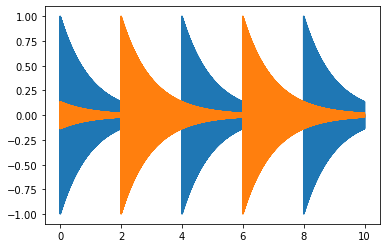

In [43]:
# criamos o som de base 
def base(t):
    return np.sin(2*np.pi*220*t)*np.exp(-t)

# definimos o canal da esquerda à partir do som de base
t_left  = 4*(t/4 - np.fix(t/4))
left   = base(t_left)

# e depois o canal da direita
t_right = 4*((t+2)/4 - np.fix((t+2)/4))
right  = base(t_right)

# e visualizamos o som criado
plt.plot(t, left)
plt.plot(t, right)

# Nesse caso o sinal é a concatenação dos dois vetores
# o do canal direito e o do canal esquerdo
Audio([left, right], rate=sr)

E se for preciso gravar o sinal de audio, então podemos fazer asim...

In [ ]:
# é preciso primeiro passar o formato ndarray, pois
# é o tipo de dado que o módulo librosa compreende...
sig = np.array([left, right])

# para salvar precisamos do nome e caminho do novo arquivo
# do sinal e de sua amostragem...
sf.write('two_channel.wav', sig.T, sr, 'PCM_32')

De maneira geral, instrumentos não criam senoides perfeitas quando manuseados. Em cada instrumento suas estruturas de fabricação  garantem qualidades sonoras diferentes um do outro, o que torna cada instrumento único. A natureza do intrumento adiciona à frequência de cada nota harmônicos que modificam sua qualidade sonora.

No piano, os harmônicos não são frequências multiplas da frequência de base. Felizmente podemos calcular essas frequências, como mostrado [aqui](https://physics.stackexchange.com/questions/268568/why-are-the-harmonics-of-a-piano-tone-not-multiples-of-the-base-frequency).

440.0
880.7693274264896
1326.138589612257
1780.6288076869005
2248.6087470760503
2734.231897607563
3241.387084999143
3773.664290236796
4334.335578760516


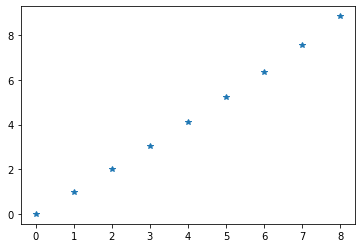

In [46]:
# https://physics.stackexchange.com/questions/268568/why-are-the-harmonics-of-a-piano-tone-not-multiples-of-the-base-frequency
B = 0.0035
n = np.linspace(0, 8, 9)
fn = n * np.sqrt(1 + B * n**2)

# Frequências harmônicas geradas à partir do dó central
# definido em 440 Hz
for i in fn:
  print(440 + (440 * i))
  
plt.plot(n, fn, '*')

In [47]:
# Função geradora para sinal que imita piano

def base2(t, fc, n):
  ans = np.zeros(t.shape)

  B = 0.0035
  h = np.linspace(0, n, n)
  fn = h * np.sqrt(1 + B * h**2)

  for i, k in enumerate(fn):
    # print(f"{(1/(i+1)**2)} : {k}")
    aux = 2 * np.pi * (fc + (fc * k))
    ans += (1/(i+1)**2) * np.sin(aux * t)

  # print(fn)
  # print(fc + (fc * fn))
  return ans

In [48]:
sig = base2(t, 261.65, 4) * np.exp(-t)

Audio([sig, sig], rate=sr)

In [49]:
# https://en.wikipedia.org/wiki/Envelope_(music)
def envelope(sig, nS=1, nA=0.05, nD=0.05, nR=0.3, sr=sr):

  if nS < (nA + nD):
    return False
  
  t_max = nS + nR

  amp_max = 1
  amp_s = 0.3

  A = int(np.fix(nA * sr))
  D = int(np.fix(nD * sr))
  S = int(np.fix(nS * sr))
  R = int(np.fix(nR * sr))

  ans = np.zeros( S + R )
  S = S - (A+D)

  ans[0:A] = np.linspace(0, amp_max, A)
  ans[A:A+D] = np.linspace(amp_max, amp_s, D)
  ans[A+D:A+D+S] = amp_s*np.ones(S)
  ans[A+D+S:A+D+S+R] = np.linspace(amp_s, 0, R)

  return np.append(sig, sig[0:R]) * ans

In [50]:
def base3(duration=1, sr=sr, fc=261.65, n=4):
  nT = np.linspace(0, duration, duration*sr)
  ans = np.zeros(nT.shape)

  B = 0.0035
  h = np.linspace(0, n, n)
  fn = h * np.sqrt(1 + B * h**2)

  for i, k in enumerate(fn):
    # print(f"{(1/(i+1)**2)} : {k}")
    aux = 2 * np.pi * (fc + (fc * k))
    ans += (1/(i+1)**2) * np.sin(aux * nT)

  return envelope(ans, nS=duration)

In [51]:
# Rt = np.linspace(0, 1, sr*1) # tempo amostrado
sig = base3(fc=261.65, duration=1, n=4)

Audio([sig, sig], rate=sr)

In [52]:
yf = abs(np.fft.fft(sig))
xf  = np.linspace(0.0, 1.0/(2.0*10), int(t.size/2))

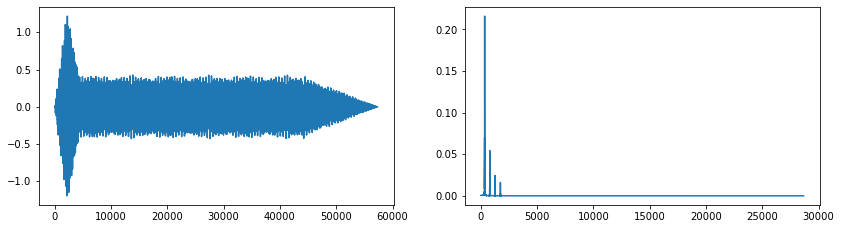

In [53]:
plt.figure(figsize = (14, 8))

plt.subplot(221)
plt.plot(sig)

plt.subplot(222)
plt.plot(2/yf.size * yf[:yf.size//2])

Com essas informações, responda às seguintes questões:

**1.** Suponha uma frequência de amostragem de $44100\,Hz$, crie uma escala de dó (do, re, mi, fa, sol, la, si, dó) com sinais senoidais variando a frequência de acordo com [essa imagem](https://github.com/rsmarinho/pdscodes/blob/master/notas_musicais.jpg) \(obtida [aqui](https://www.researchgate.net/figure/Notas-e-frequencias-no-teclado-do-piano-MASLINKIEWICZ-COELHO-2012-p-91_fig1_275250294)\). Cada nota deve ter a duração de um segundo, o que totalizará um sinal de audio de oito segundos de duração. Utilize como base o dó central.

In [ ]:
sr = 
t = np.linspace(0, 8, sr)

def escala(t):
  # a criação da escala vai aqui
  data = 
  return data

sig = escala(t)

Audio(sig, rate=sr)

**2.** Experimente mudar a taxa de amostragem (**sr**) para a metade da taxa de amostragem do sinal original? Nesse caso, quais serão as *novas* frequências de cada nota? Analise o **novo** sinal quanto sua duração. O que aconteceu? Com base em seus conhecimentos da teoria de sinais e sistemas, tente explicar o que acontece quando modificamos a taxa de amostragem.

**3.** Um acorde é a junção de várias notas tocadas ao mesmo tempo. Em processamento digital de audio, podemos compreender um acorde como uma sobreposição de vários sinais de frequências diferentes. O acorde de dó maior é formado pelas notas \<dó, mi, sol\>. Novamente, com a ajuda do [mapa de frequências](https://github.com/rsmarinho/pdscodes/blob/master/notas_musicais.jpg) crie um acorde de dó com duração de três segundos.

In [ ]:
sr = 
t = np.linspace(0, 3, sr)

def acorde(t):
  # a criação da escala vai aqui
  data = 
  return data

sig = acorde(t)

Audio(sig, rate=sr)

**5.** Coloque a escala de dó (gerada na questão **1**) e o acorde de dó (gerado na questão **3**), um em cada canal e salve o resultado em um arquivo. Lembrem-se de que o tempo total tem que ser o mesmo para que a soma dê certo.

**6.** A função $base3()$ gera um sinal com a "nota" definida por uma frequência em Hertz. Note que a função base3 funciona da mesma maneira que a função $base2()$, exceto que a primeira modifica a amplitude do sinal para que ele tenha determinado [**envelope**](https://en.wikipedia.org/wiki/Envelope_(music)).

Nessa questão, modifique a função envelope de tal forma que o $decay$, $sustain$ e $release$ da nota obedeçam exponenciais negativas, mas que o sinal não tenha descontinuidades.